In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import shutil, random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import (
    DataBlock, ImageBlock, CategoryBlock, get_image_files,
    GrandparentSplitter, parent_label, Resize, aug_transforms,
    vision_learner, accuracy, ClassificationInterpretation, resnet34)
from fastai.torch_core import default_device
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time

In [2]:
# device selection
def set_device():
    if torch.cuda.is_available(): default_device('cuda'); print('使用CUDA加速')
    elif torch.backends.mps.is_available(): default_device('mps'); print('使用MPS加速')
    else: default_device('cpu'); print('使用CPU')
set_device()

使用CPU


In [3]:
def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # Remove existing destination directory if it exists
    if dest_base_path.exists():
        shutil.rmtree(dest_base_path)
    
    # Create destination directories
    for phase in ['train', 'valid', 'test']:
        for cat in categories:
            os.makedirs(dest_base_path/phase/cat, exist_ok=True)
    
    # Split and copy files for each category
    for cat in categories:
        files = list((Path(src_base_path)/cat).glob('*.*'))
        random.shuffle(files)
        n = len(files)
        
        # Calculate split indices
        train_end = int(n * train_ratio)
        valid_end = train_end + int(n * valid_ratio)
        
        # Split files into three sets
        train_files = files[:train_end]
        valid_files = files[train_end:valid_end]
        test_files = files[valid_end:]
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy(f, dest_base_path/'train'/cat/f.name)
        for f in valid_files:
            shutil.copy(f, dest_base_path/'valid'/cat/f.name)
        for f in test_files:
            shutil.copy(f, dest_base_path/'test'/cat/f.name)
        
        # Print statistics for each category
        print(f"\nCategory: {cat}")
        print(f"Total files: {n}")
        print(f"Train set: {len(train_files)} files")
        print(f"Valid set: {len(valid_files)} files")
        print(f"Test set: {len(test_files)} files")
        
        # Verify the splits
        assert len(train_files) + len(valid_files) + len(test_files) == n, \
            f"Split verification failed for category {cat}"
    
    # Print overall statistics
    print("\nOverall Dataset Statistics:")
    for phase in ['train', 'valid', 'test']:
        total_files = sum(len(list((dest_base_path/phase/cat).glob('*.*'))) 
                        for cat in categories)
        print(f"{phase.capitalize()} set: {total_files} files")

In [5]:
src_base_path = Path('Felidae')
dest_base_path = Path('images')
cats = ['Desert cat', 'MaineCoon','Siberian Cats']
split_dataset(src_base_path, dest_base_path, cats, 0.6, 0.2, 0.2)
seed = 42


Category: Desert cat
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Category: MaineCoon
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Category: Siberian Cats
Total files: 50
Train set: 30 files
Valid set: 10 files
Test set: 10 files

Overall Dataset Statistics:
Train set: 90 files
Valid set: 30 files
Test set: 30 files


In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224)
)
dls = dblock.dataloaders(dest_base_path, bs=64)
seed = 42

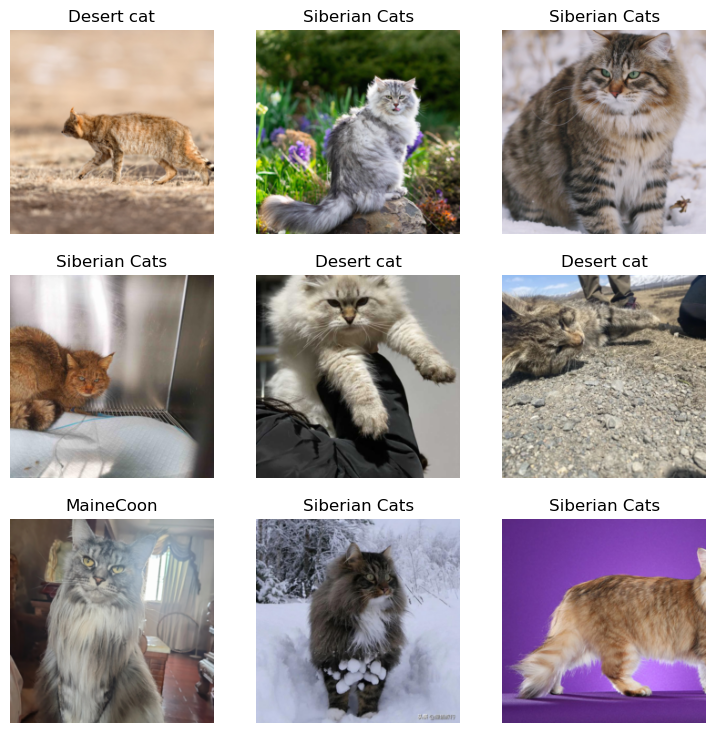

In [9]:
dls.show_batch()

In [13]:



from torchvision.models import resnet18
learn = vision_learner(dls, resnet18, metrics=accuracy, cbs=[early_stop_cb, save_model_cb])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 13.9MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.123281,0.788295,0.833333,00:07
1,0.088422,0.761323,0.833333,00:07
2,0.080830,0.709339,0.833333,00:07
3,0.062713,0.658575,0.766667,00:07
4,0.051110,0.625188,0.766667,00:07
5,0.042831,0.594798,0.766667,00:07
6,0.036624,0.571345,0.766667,00:06
7,0.031974,0.555593,0.800000,00:06
8,0.028314,0.543597,0.800000,00:07
9,0.025659,0.527143,0.800000,00:07


Better model found at epoch 0 with valid_loss value: 0.7882949709892273.
Better model found at epoch 1 with valid_loss value: 0.7613229751586914.
Better model found at epoch 2 with valid_loss value: 0.7093394994735718.
Better model found at epoch 3 with valid_loss value: 0.6585754752159119.
Better model found at epoch 4 with valid_loss value: 0.6251882910728455.
Better model found at epoch 5 with valid_loss value: 0.594797670841217.
Better model found at epoch 6 with valid_loss value: 0.5713452100753784.
Better model found at epoch 7 with valid_loss value: 0.5555928349494934.
Better model found at epoch 8 with valid_loss value: 0.5435969829559326.
Better model found at epoch 9 with valid_loss value: 0.5271432995796204.


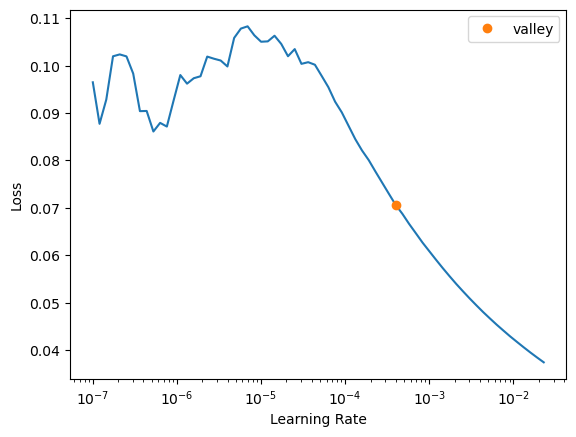

In [21]:
# 在模型训练前添加学习率探测
learn.lr_find()

# 会输出学习率曲线图，寻找最陡峭下降区域的起点
# 典型用法（在后续训练中使用）：
learn.fit_one_cycle(10, lr_max=1e-3)  # 使用探测结果中的推荐值替代1e-3

In [22]:
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=5, min_delta=0.01)
save_model_cb = SaveModelCallback(monitor='valid_loss', fname='best_model')

In [23]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,accuracy,time


Better model found at epoch 0 with valid_loss value: 0.5195252895355225.


epoch,train_loss,valid_loss,accuracy,time
0,0.002120,0.513228,0.800000,00:07
1,0.002124,0.510203,0.833333,00:06
2,0.002771,0.507875,0.800000,00:06
3,0.003001,0.508765,0.833333,00:06
4,0.002648,0.513045,0.833333,00:07
5,0.002301,0.512499,0.833333,00:07


Better model found at epoch 0 with valid_loss value: 0.5132278800010681.
Better model found at epoch 1 with valid_loss value: 0.5102026462554932.
Better model found at epoch 2 with valid_loss value: 0.5078745484352112.
No improvement since epoch 0: early stopping


In [24]:
test_dl = dls.test_dl(get_image_files(dest_base_path/'test'), with_labels=True)
loss, acc = learn.validate(dl=test_dl)

Better model found at epoch 0 with valid_loss value: 0.7333333492279053.


In [25]:
loss

1.1760096549987793

In [26]:
acc

0.7333333492279053

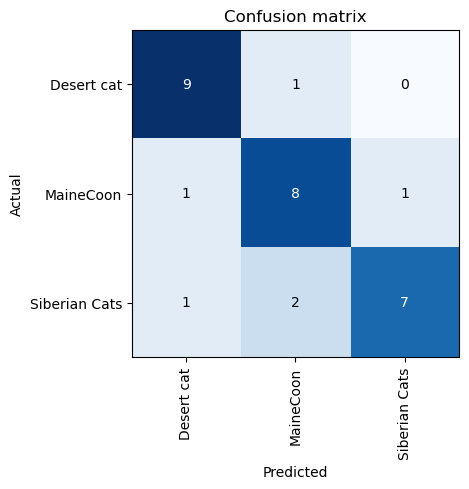

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [28]:
interp.print_classification_report()

               precision    recall  f1-score   support

   Desert cat       0.82      0.90      0.86        10
    MaineCoon       0.73      0.80      0.76        10
Siberian Cats       0.88      0.70      0.78        10

     accuracy                           0.80        30
    macro avg       0.81      0.80      0.80        30
 weighted avg       0.81      0.80      0.80        30



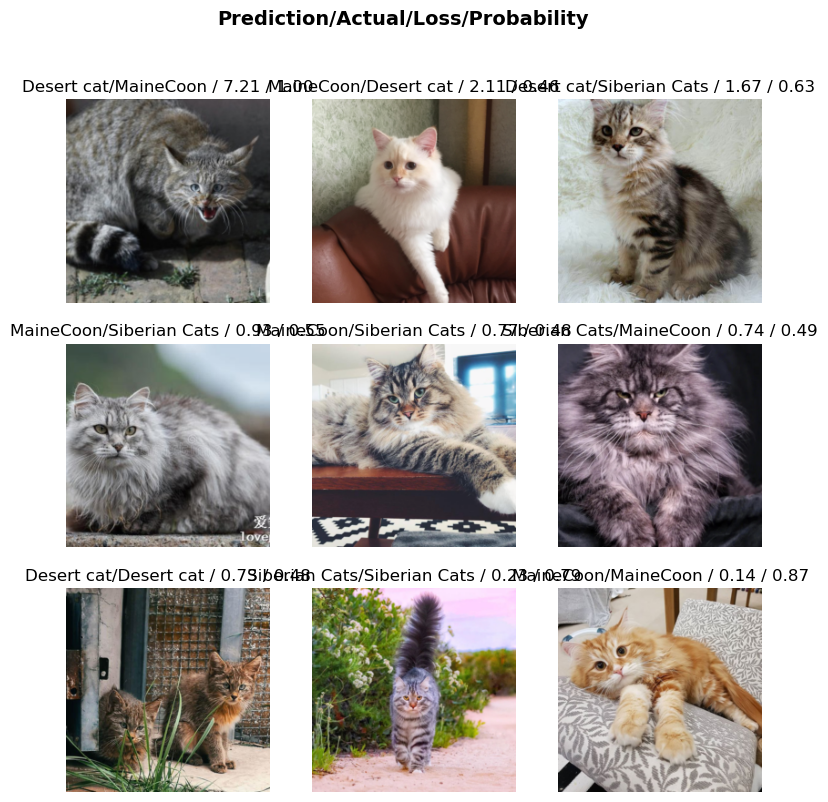

In [29]:
interp.plot_top_losses(9)

In [30]:
learn.export('cats.pkl')

In [31]:
from fastai.vision.all import * # 导入 fastai 视觉库的所有模块


from torchcam.methods import CAM, SmoothGradCAMpp # 从 torchcam 库导入 CAM 和 SmoothGradCAMpp 方法
from torchvision.transforms import Compose, Resize, ToTensor, Normalize # 从 torchvision 导入图像变换相关类
from torchvision.transforms.functional import to_pil_image # 从 torchvision.transforms.functional 导入将 Tensor 转换为 PIL 图像的函数
from PIL import Image # 导入 PIL 库用于图像处理
from torchcam.utils import overlay_mask # 从 torchcam 库导入用于叠加掩码的工具函数

In [32]:
def visualize_cam(learner, image_path, cam_class=SmoothGradCAMpp):
    """
    可视化指定图像的类激活图 (CAM)。

    参数:
        learner: fastai 的 Learner 对象，包含了训练好的模型。
        image_path (str): 需要可视化的图像文件路径。
        cam_class (type): 用于生成 CAM 的类，默认为 SmoothGradCAMpp。
    """
    # 加载图像文件，并确保图像是 RGB 格式
    img = Image.open(image_path).convert('RGB')

    # 定义一系列图像预处理步骤
    preprocess = Compose([
        Resize(224), # 将图像大小调整为 224x224 像素
        ToTensor(), # 将 PIL 图像转换为 PyTorch Tensor
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # 使用 ImageNet 的均值和标准差对图像进行标准化
    ])

    # 应用预处理步骤到加载的图像上
    input_tensor = preprocess(img)
    # 在 Tensor 的第 0 维增加一个维度，以符合模型输入的 batch 要求 (batch_size=1)
    input_tensor = input_tensor.unsqueeze(0)

    # 从 Learner 对象中获取底层的 PyTorch 模型，并设置为评估模式 (eval mode)
    # 评估模式会关闭 dropout 和 batch normalization 的更新
    model = learner.model.eval()

    # 使用指定的 CAM 类初始化 CAM 提取器，并将其作为上下文管理器使用
    # 这样可以确保资源被正确管理
    with cam_class(model) as cam_extractor:
        # 将预处理后的图像 Tensor 输入模型，获取模型的输出分数 (logits)
        scores = model(input_tensor)

        # 从模型输出中移除 batch 维度，然后找到分数最高的那个类别的索引
        pred_class_idx = scores.squeeze(0).argmax().item()

        # 使用 CAM 提取器计算指定预测类别的激活图
        # cam_extractor 返回的是一个包含激活图的列表，我们取第一个元素
        activation_map = cam_extractor(pred_class_idx, scores)[0]

    # 将计算得到的激活图 (通常是单通道的浮点数 Tensor) 转换回 PIL 图像格式
    # mode='F' 表示输入是 32 位浮点数
    # .cpu() 是因为 to_pil_image 需要 CPU Tensor
    heatmap_pil = to_pil_image(activation_map.cpu(), mode='F')

    # 将生成的激活图 (热力图) 叠加到原始图像上
    # alpha 参数控制热力图的透明度
    overlayed_img = overlay_mask(img, heatmap_pil, alpha=0.5)

    # 创建一个新的 matplotlib 图形窗口来显示结果
    plt.figure(figsize=(6, 6)) # 可以调整图形大小
    # 显示叠加了热力图的图像
    plt.imshow(overlayed_img)
    # 设置图像标题，包含所使用的 CAM 方法的名称
    plt.title(f"{cam_class.__name__} 叠加效果")
    # 关闭坐标轴显示
    plt.axis('off')
    # 显示图形
    plt.show()

In [41]:
def visualize_random_images(learner, desert_cat_dir='images/test/Desert Cat', 
                            maine_coon_dir='images/test/MaineCoon',
                            siberian_cats_dir='images/test/Siberian Cats'):
    """
    随机选择并可视化不同猫类别的 CAM 效果
    参数:
        learner: fastai 的 Learner 对象
        desert_cat_dir: 沙漠猫图片目录路径
        maine_coon_dir: 缅因猫图片目录路径
        siberian_cats_dir: 西伯利亚猫图片目录路径
    """
    # 获取图片文件
    desert_cat_images = os.listdir(desert_cat_dir)
    maine_coon_images = os.listdir(maine_coon_dir)
    siberian_cats_images = os.listdir(siberian_cats_dir)

    # 随机选择图片
    desert_cat_image = random.choice(desert_cat_images)
    maine_coon_image = random.choice(maine_coon_images)
    siberian_cat_image = random.choice(siberian_cats_images)

    # 构建完整路径
    desert_cat_path = os.path.join(desert_cat_dir, desert_cat_image)
    maine_coon_path = os.path.join(maine_coon_dir, maine_coon_image)
    siberian_cat_path = os.path.join(siberian_cats_dir, siberian_cat_image)

    print(f"随机选择的沙漠猫图片: {desert_cat_path}")
    print(f"随机选择的缅因猫图片: {maine_coon_path}") 
    print(f"随机选择的西伯利亚猫图片: {siberian_cat_path}")

    # 可视化 CAM 效果
    visualize_cam(learn, desert_cat_path)
    visualize_cam(learn, maine_coon_path)
    visualize_cam(learn, siberian_cat_path)

In [42]:
learn = load_learner('cats.pkl')

c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


随机选择的沙漠猫图片: images/test/Desert Cat\DesertCat-26.jpg
随机选择的缅因猫图片: images/test/MaineCoon\MaineCoon-9.jpg
随机选择的西伯利亚猫图片: images/test/Siberian Cats\SiberianCats-19.png


c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21472 (\N{CJK UNIFIED IDEOGRAPH-53E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ASUS\anaconda3\envs\datascience\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


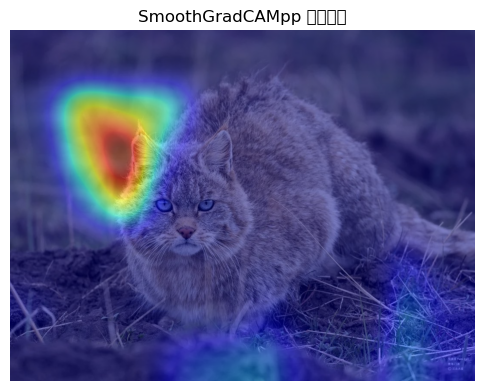

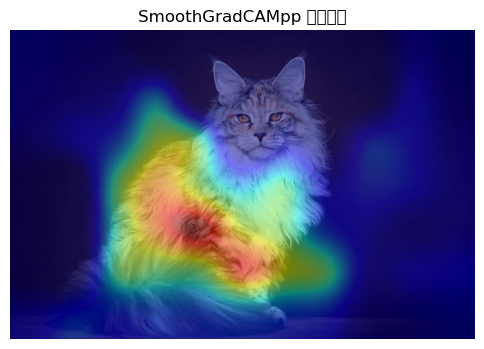

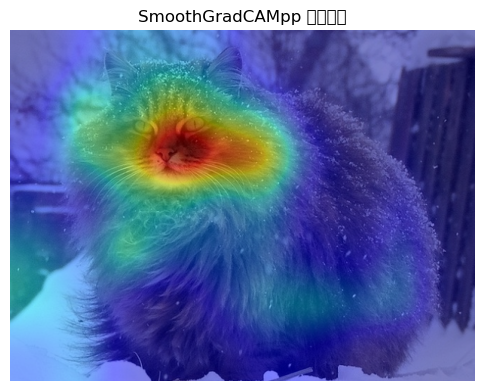

In [43]:
visualize_random_images(learn)